In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
#df.shape
train_df.sample(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
197,198,0,3,"Olsen, Mr. Karl Siegwart Andreas",male,42.0,0,1,4579,8.4042,NaN,S
836,837,0,3,"Pasic, Mr. Jakob",male,21.0,0,0,315097,8.6625,NaN,S


In [3]:
male_live = train_df.loc[train_df.Sex == 'male']['Survived']
female_live = train_df.loc[train_df.Sex == 'female']['Survived']
male_rate = sum(male_live)/len(male_live)
female_rate = sum(female_live)/len(female_live)

print("male survive rate: %s \nfemale survive rate: %s" %(male_rate, female_rate))

male survive rate: 0.18890814558058924 
female survive rate: 0.7420382165605095


In [4]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

display_missing(train_df)
display_missing(test_df)

PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




In [5]:
train_df[["Age", "Survived"]].groupby(['Age'], as_index=False).mean()

,Age,Survived
0,0.42,1.0
1,0.67,1.0
2,0.75,1.0
3,0.83,1.0
4,0.92,1.0
...,...,...
83,70.00,0.0
84,70.50,0.0
85,71.00,0.0
86,74.00,0.0


In [6]:
from plotnine import *



In [7]:
#data clean
test_df['Fare'].fillna(test_df['Fare'].mean(), inplace = True)
test_df['Age'].fillna(test_df['Age'].mean(), inplace = True)
train_df['Age'].fillna(train_df['Age'].mean(), inplace = True)
train_df['Embarked'].fillna('C', inplace = True)

In [8]:
train_df[['Pclass', 'Fare']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Fare', ascending=False)

,Pclass,Fare
0,1,84.154687
1,2,20.662183
2,3,13.675550


In [9]:
#train_df['Cabin'].sample(5)
# group these cabins according to the letter of the cabin name
train_df.Cabin = [str(i)[0] for i in train_df.Cabin]
test_df.Cabin = [str(i)[0] for i in test_df.Cabin]
all_df = pd.concat([train_df, test_df])
cb = all_df.groupby(["Cabin"], as_index=False)['Fare'].mean().sort_values(by = 'Fare')
all_df['Cabin'].value_counts()

n    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

In [10]:
def cabin_seg(i):
    a = 0
    if i<16:
        a = "G"
    elif i>=16 and i<27:
        a = "F"
    elif i>=27 and i<38:
        a = "T"
    elif i>=38 and i<47:
        a = "A"
    elif i>= 47 and i<53:
        a = "E"
    elif i>= 53 and i<54:
        a = "D"
    elif i>=54 and i<116:
        a = 'C'
    else:
        a = "B"
    return a

train_df['Cabin'] = train_df['Fare'].apply(lambda x : cabin_seg(x))
test_df['Cabin'] = test_df['Fare'].apply(lambda x : cabin_seg(x))

/tmp/ipykernel_20/438324630.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


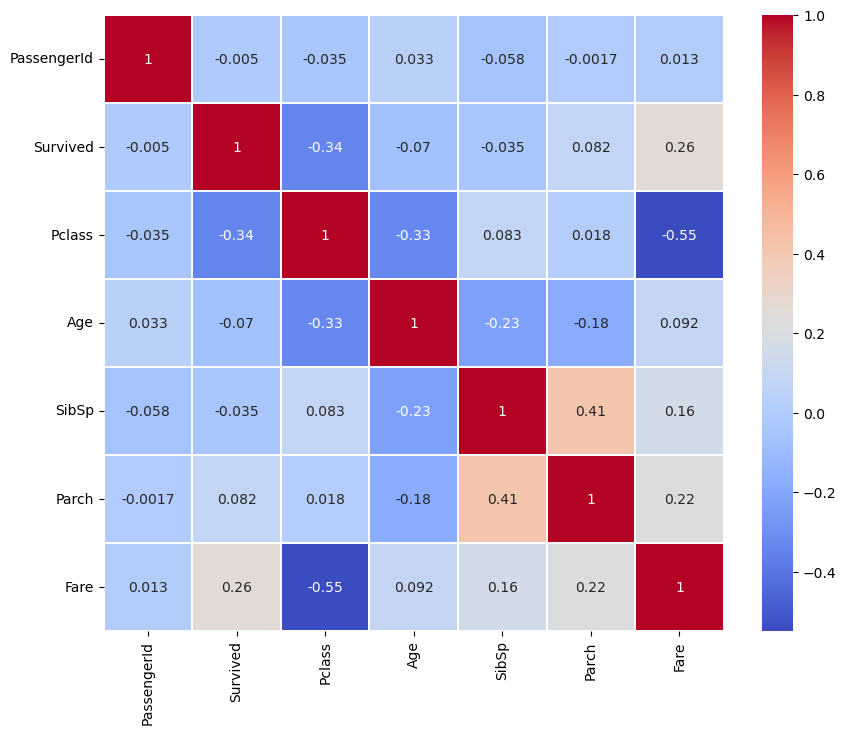

In [11]:
#from plotnine import *  # plotnine is an implementation of a grammar of graphics in Python, it is based on ggplot2. The grammar allows users to compose plots by explicitly mapping data to the visual objects that make up the plot.
import matplotlib.pyplot as plt  # collection of command style functions that make matplotlib work like MATLAB
import seaborn as sns  # statistical data visualization

sns.heatmap(train_df.corr(),annot=True,cmap='coolwarm', linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [12]:
from sklearn.ensemble import RandomForestClassifier

y = train_df["Survived"]

features = ["Pclass", "Sex", 'Fare', 'Cabin', 'Embarked']
X = pd.get_dummies(train_df[features])
X_test = pd.get_dummies(test_df[features])


model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")


Your submission was successfully saved!
